In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import json

from pyinstrument import Profiler
%load_ext pyinstrument

from sklearn import set_config
set_config(assume_finite=True) 

import matplotlib.pyplot as plt
import datetime as dt

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


# Procedure for generating VoC curves

1. Generate 120000 RFFs using `make_RFF`
2. For $t \in \{12, \dots, len(S)\}$:
   1. Standardize the RFFs by their standard deviation in the training sample i.e. sample $\{S_{t-T}, \dots S_{t-1}\}$ of the last $T$ observations, for $T \in \{12, 60, 120\}$. Also, standardize $S_{t}$ by the same standard deviation. Output `NaN` if $t < T$.
   2. Estimate the model by ridge regression with $P\in \{2,\dots, 12000\}$ and ridge shrinkage parameter $log_{10}(z) \in \{−3,\dots, 3\}$. In our case we are taking 9 values for $P$ and 7 values for $z$, so we have 63 models to estimate for each $t$.
3. From the sequence of out-of-sample predictions and strategy returns in step 2. calculate:
   1. average $||\hat{\beta}||^2$ across training samples,
   2. out-of-sample $R^2$ 
   3. out-of-sample average return of the timing strategy
   4. volatility of the timing strategy
   5. Sharpe ratio of the timing strategy


In the following subsections of the notebook we inspect each of the steps, check the results of each step and profile the code in each step to identify bottlenecks.

## 1. Generate RFFs

In [10]:
data = pd.read_csv("../data/processed/processed_data.csv", index_col=0, parse_dates=True)
P=12000 # number of pairs
gamma=2

def make_RFF(data, P, gamma=2, seed=59148):
    np.random.seed(seed)
    omegas = np.random.normal(0, 1, (15, int(P/2)))
    G=data.iloc[:,:-1] # remove last column which is the target variable
    A = gamma * G @ omegas
    A_sin = np.sin(A).rename(columns=lambda x: int(x*2)) 
    A_cos = np.cos(A).rename(columns=lambda x: int(x*2+1)) 
    A_combined = pd.concat([A_sin, A_cos], axis=1)
    S = A_combined.reindex(np.arange(P), axis=1, copy=True)  # reorder columns by index
    return S

In [11]:
S = make_RFF(data=data, P=P, gamma=gamma, seed=59148)
R = data.iloc[:,-1] # target variable, it is already shifted

In [12]:
S # ok

,0,1,2,3,4,5,6,7,8,9,...,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999
date,,,,,,,,,,,,,,,,,,,,,
1929-12-31,-0.586592,0.809882,0.960207,0.279289,0.278348,0.960480,-0.995590,-0.093816,-0.783301,-0.621642,...,0.405067,-0.914287,-0.935883,0.352312,-0.401934,-0.915668,-0.998875,-0.047411,0.769336,0.638845
1930-01-31,-0.843060,0.537820,-0.650093,0.759855,0.051358,0.998680,0.924008,0.382373,0.990375,-0.138407,...,-0.980734,-0.195348,-0.128761,-0.991676,-0.748806,0.662790,0.637735,0.770256,-0.855858,0.517210
1930-02-28,-0.740483,-0.672075,0.937908,0.346884,0.922893,-0.385056,-0.783720,0.621114,-0.978881,0.204433,...,-0.498489,0.866896,0.921926,0.387366,-0.983286,0.182066,-0.936369,-0.351018,-0.924716,0.380658
1930-03-31,-0.982123,-0.188241,0.978992,0.203899,-0.857578,0.514354,-0.724637,-0.689131,0.049213,-0.998788,...,0.962989,-0.269540,-0.548515,-0.836141,-0.155157,0.987890,-0.324882,-0.945754,-0.852245,-0.523143
1930-04-30,-0.961807,0.273730,-0.987082,0.160213,-0.414094,0.910234,-0.974284,-0.225324,0.175359,-0.984505,...,-0.034479,-0.999405,0.985866,-0.167538,-0.152865,-0.988247,0.563171,0.826341,-0.880031,0.474917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,-0.597413,-0.801934,-0.831091,0.556136,-0.964548,0.263909,-0.999994,0.003398,-0.663326,0.748331,...,-0.983899,0.178726,0.286716,-0.958016,0.979963,-0.199179,0.073882,0.997267,0.705948,-0.708264
2022-08-31,0.949060,0.315096,-0.765251,0.643732,0.979025,-0.203741,-0.124336,0.992240,-0.952292,-0.305188,...,0.797294,0.603592,-0.779976,-0.625810,0.264745,-0.964318,-0.010178,0.999948,0.463539,0.886077
2022-09-30,0.994313,-0.106500,0.917248,0.398317,0.718846,0.695169,-0.745063,0.666994,-0.942984,-0.332839,...,-0.584073,-0.811701,0.912448,-0.409192,0.988264,0.152756,-0.198633,0.980074,-0.797129,0.603810


In [13]:
R

date
1929-12-31    0.680051
1930-01-31    0.277740
1930-02-28    0.810971
1930-03-31   -0.190234
1930-04-30   -0.153955
                ...   
2022-07-31   -0.745281
2022-08-31   -1.524433
2022-09-30    1.237698
2022-10-31    0.792841
2022-11-30   -0.953139
Name: R, Length: 1116, dtype: float64

### 1.1 Profiling

In [14]:
%%pyinstrument
S = make_RFF(data=data, P=P, gamma=gamma)
# 0.45s cashed, 3.9-4.7s uncached 
# apply takes 70% time

_     ._   __/__   _ _  _  _ _/_   Recorded: 15:16:25  Samples:  30
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.488     CPU time: 1.306
/   _/                      v4.6.2

Program: /home/miroslav/miniforge3/envs/voc/lib/python3.12/site-packages/ipykernel_launcher.py --f=/home/miroslav/.local/share/jupyter/runtime/kernel-v2-1370969VpA5WP0MGu8z.json

0.488 <module>  ../../../../../../../tmp/ipykernel_1445177/2698441166.py:1
`- 0.486 make_RFF  ../../../../../../../tmp/ipykernel_1445177/1102542553.py:5
   |- 0.288 DataFrame.__array_ufunc__  pandas/core/generic.py:2167
   |     [4 frames hidden]  pandas
   |        0.288 NumpyBlock.apply  pandas/core/internals/blocks.py:387
   |- 0.057 DataFrame.rename  pandas/core/frame.py:5636
   |     [9 frames hidden]  pandas, <built-in>
   |- 0.049 concat  pandas/core/reshape/concat.py:157
   |     [8 frames hidden]  pandas, <built-in>
   |- 0.049 DataFrame.__matmul__  pandas/core/frame.py:1783
   |     [2 frames hidden]  pandas
   `- 0.041 DataFrame.reindex  pandas/core/frame.py:5359
         [9 frames hidden]  pandas

Let's try to improve the performance can be done by switching from pandas dataframe to numpy arrays.

In [15]:
G=data.iloc[:,:-1].values # remove last column which is the target variable
G

array([[ 9.13788829,  0.        ,  0.99611347, ...,  4.64768779,
         4.44483069, -2.06545938],
       [ 8.74478495, -0.90263792,  0.14155092, ...,  4.37144973,
         3.99673464,  0.46338983],
       [ 8.26222406, -0.91273557,  0.17250821, ...,  4.35133748,
         3.98236255,  1.0025477 ],
       ...,
       [ 1.62070993, -0.06722329,  0.82206722, ...,  0.93036597,
        -0.43938156, -0.74327159],
       [ 1.70985273,  0.40814285,  1.0840119 , ...,  0.81626823,
        -0.59336538, -1.68547048],
       [ 1.72533774,  0.7700837 ,  1.05745214, ...,  0.77223004,
        -0.66160578,  1.47783364]])

In [16]:
def make_RFF_np(data, P, gamma=2, seed=59148):
    np.random.seed(seed)

    def generate_omegas():
        return np.random.normal(0, 1, (15, int(P/2)))
    omegas = generate_omegas()

    def make_A(data, gamma, omegas):
        return gamma * data @ omegas
    A = make_A(data, gamma, omegas)
    
    def make_S(A):
        S_sin = np.sin(A) 
        S_cos = np.cos(A)
        return S_sin, S_cos
    S_sin, S_cos = make_S(A)
    # combine sin and cos parts into one matrix S by making sin take even columns and cos take odd columns
    
    def combine_sin_cos(S_sin, S_cos):
        S = np.full((S_sin.shape[0], S_sin.shape[1] + S_cos.shape[1]), fill_value=np.nan, dtype=S_sin.dtype)
        S[:, 0::2] = S_sin
        S[:, 1::2] = S_cos
        return S

    return combine_sin_cos(S_sin, S_cos)

In [17]:
%%pyinstrument
S = make_RFF_np(data=G, P=P, gamma=gamma)

# 0.4-0.5s cashed, 3.5s uncached
# main bottleneck is applying sin and cos to A (70% of time)

_     ._   __/__   _ _  _  _ _/_   Recorded: 15:16:25  Samples:  6
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.477     CPU time: 1.416
/   _/                      v4.6.2

Program: /home/miroslav/miniforge3/envs/voc/lib/python3.12/site-packages/ipykernel_launcher.py --f=/home/miroslav/.local/share/jupyter/runtime/kernel-v2-1370969VpA5WP0MGu8z.json

0.476 <module>  ../../../../../../../tmp/ipykernel_1445177/1926690765.py:1
`- 0.474 make_RFF_np  ../../../../../../../tmp/ipykernel_1445177/383780573.py:1
   |- 0.315 make_S  ../../../../../../../tmp/ipykernel_1445177/383780573.py:12
   |- 0.081 make_A  ../../../../../../../tmp/ipykernel_1445177/383780573.py:8
   `- 0.075 combine_sin_cos  ../../../../../../../tmp/ipykernel_1445177/383780573.py:19
      |- 0.050 [self]  ../../../../../../../tmp/ipykernel_1445177/383780573.py
      `- 0.025 full  numpy/core/numeric.py:274

No significant improvement is made. No need for further inspections, since `make_RFF` will be called 1000 times in the main loop ().

It should be noted that the speed is heavily dependent on caching of the data, which is done in the step when the data is loaded from the csv. For non-cached data, the speed is significantly slower (~ 10 times), comes to around 4 seconds per run. So, in the worst case scenario, the total time for this step would be 1000 * 4 = 4000 seconds ~ 1 hour.

The final function to be used:

In [18]:
def make_rff(G, P, gamma=2, seed=59148, output_type='numpy'):
    np.random.seed(seed)
    omegas = np.random.normal(0, 1, (15, int(P/2)))
    A = gamma * G @ omegas
    S_sin = np.sin(A) 
    S_cos = np.cos(A)
    S = np.full((S_sin.shape[0], S_sin.shape[1] + S_cos.shape[1]), fill_value=np.nan, dtype=S_sin.dtype)
    S[:, 0::2] = S_sin
    S[:, 1::2] = S_cos

    if output_type == 'pandas':
        S = pd.DataFrame(data=S, index=G.index, columns=np.arange(P))
    elif output_type == 'numpy':
        return S
    else:
        raise ValueError('output_type must be "pandas" or "numpy"')

In [19]:
data = pd.read_csv("../data/processed/processed_data.csv", index_col=0, parse_dates=True)
P=12000 # number of pairs
gamma=2

# inputs
G = data.iloc[:,:-1].values # remove last column which is the target variable
R = data.iloc[:,-1].values # target variable, it is already shifted
S = make_rff(G, P, gamma=gamma, output_type='numpy')

## 2. Model fitting

[VoC] (regularized) least-squares estimators of the form

$$ \hat{\beta}(z) = \left( zI + T^{-1} \sum_t S_t S_t' \right)^{-1} \frac{1}{T} \sum_t S_t R_{t+1}$$

The ridge regression in The Elements of Statistical Learning (Hastie et al., 2009) is equivalent to the above equation with $z = \lambda T$ and given as 

$$ \hat{\beta}(\lambda) = \left( \lambda I + X^T X \right)^{-1}X^Ty$$

In [26]:
def single_run(run_inputs, run_params, delta_t=1):
    """
    Run the backtest for a single run.
    S: matrix of features
    R: vector of target variable, shifted once 
    T_list: list of training window lengths
    model_list: list of models to train (ridge regressions with different lambdas)
    P_list: list of number of features to use for each model
    delta_t: time step for retraining the model

    Returns:
    """

    S, R = run_inputs
    T_list, P_list, model_dict = run_params

    # initialize arrays for storing results
    num_of_models = len(model_dict[T_list[0]])

    min_T = min(T_list) # usually =12

    # dimensions: (ts, Ts, Ps, lambdas)
    output_shape = (len(S)-min_T, len(T_list), len(P_list), num_of_models)
    beta_norm_sq = np.full(shape=output_shape, 
                    fill_value=np.nan, 
                    dtype=np.float64)
    return_forecasts = np.full(shape=output_shape, 
                               fill_value=np.nan, 
                               dtype=np.float64)
    strategy_returns = np.full(shape=output_shape, 
                               fill_value=np.nan, 
                               dtype=np.float64)

    # initialize arrays for storing intermediate variables
    # training_std = np.full((len(T_arr), S.shape[1]), fill_value=np.nan, dtype=np.float64)

    def my_std(x):
        return np.sqrt(np.sum(np.square(x - x.mean(axis=0)))/len(x))

    def standardize(t):
        training_sets = []

        for T in T_list:

            # this take a lot of time to compute
            # train_std = trainX.std(axis=0) 
            # train_std = np.sqrt(np.sum((trainX - train_mean)**2, axis=0)/T) # this is equivalent to trainX.std(axis=0)
            if t-T < 1:
                training_sets.append((np.nan, np.nan))
            else:
                training_std = my_std(S[t-T:t])
                trainX = S[t-T:t] / training_std
                forecastX = S[t] / training_std
                training_sets.append((trainX, forecastX))

        return training_sets

    grid = [(P_index, model_index) 
            for P_index in range(len(P_list)) 
            for model_index in range(num_of_models)]
    

    for t in range(min_T, len(S), delta_t):
        # print progress
        if t%100==0:
            print(f"progress: {t/(len(S)-min_T):2.1%}")

        # one standardization for all models, all complexities
        training_sets = standardize(t)

        for P_index, model_index in grid:
            for T_index in range(len(T_list)):
                T = T_list[T_index]

                if t-T < 1:
                    continue
                else: 
                    P = P_list[P_index]
                    # get model of appropriate shrinkage lambda=T*z, z is tracked by model_index
                    model = model_dict[T][model_index]
                    
                    trainX, forecastX = training_sets[T_index]
                    trainY = R[t-T:t]
                    # take first P features for training
                    model.fit(trainX[:,:P], trainY) 
                    forecastY = model.predict(forecastX[:P].reshape(1,-1))

                    # store results 
                    beta_norm_sq[t-min_T, T_index, P_index, model_index] = np.sum(np.square(model.coef_))
                    return_forecasts[t-min_T, T_index, P_index, model_index] = forecastY[0]
                    strategy_returns[t-min_T, T_index, P_index, model_index] = forecastY[0] * R[t]

    return beta_norm_sq, return_forecasts, strategy_returns

In [27]:
# test run
T_list = [60, 120]
z_list = [0.01, 100]
model_dict = {T: [Ridge(alpha=T*z, solver="auto", fit_intercept = False) for z in z_list] for T in T_list}
P_list = [32768, 12000]
delta_t=1

run_inputs = (S, R)
run_params = (T_list, P_list, model_dict)

In [28]:
%%pyinstrument
b, r, sr = single_run(run_inputs, run_params, delta_t)

progress: 9.5%
progress: 18.9%
progress: 28.4%
progress: 37.9%
progress: 47.3%
progress: 56.8%
progress: 66.3%
progress: 75.8%
progress: 85.2%
progress: 94.7%
progress: 104.2%


_     ._   __/__   _ _  _  _ _/_   Recorded: 15:18:11  Samples:  43399
 /_//_/// /_\ / //_// / //_'/ //     Duration: 139.790   CPU time: 998.014
/   _/                      v4.6.2

Program: /home/miroslav/miniforge3/envs/voc/lib/python3.12/site-packages/ipykernel_launcher.py --f=/home/miroslav/.local/share/jupyter/runtime/kernel-v2-1370969VpA5WP0MGu8z.json

139.789 <module>  ../../../../../../../tmp/ipykernel_1445177/4008075110.py:1
`- 139.788 single_run  ../../../../../../../tmp/ipykernel_1445177/871893489.py:1
   |- 110.399 wrapper  sklearn/base.py:1457
   |     [15 frames hidden]  sklearn, <built-in>
   |        82.152 safe_sparse_dot  sklearn/utils/extmath.py:164
   |        `- 81.749 [self]  sklearn/utils/extmath.py
   |- 19.576 standardize  ../../../../../../../tmp/ipykernel_1445177/871893489.py:40
   |  |- 13.889 my_std  ../../../../../../../tmp/ipykernel_1445177/871893489.py:37
   |  |  |- 9.491 [self]  ../../../../../../../tmp/ipykernel_1445177/871893489.py
   |  |  |- 2.635 _mean  numpy/core/_methods.py:101
   |  |  |     [2 frames hidden]  numpy, <built-in>
   |  |  `- 1.708 sum  numpy/core/fromnumeric.py:2177
   |  |        [3 frames hidden]  numpy, <built-in>
   |  `- 5.637 [self]  ../../../../../../../tmp/ipykernel_1445177/871893489.py
   `- 9.434 Ridge.predict  sklearn/linear_model/_base.py:272
         [4 frames hidden]  sklearn

### 2.1 Profiling

50s for 8 points in 2x2x2 P-z-T grid, i.e. 6.5s per node.

Goal:
- $P \in [2, 8, 32, 128, 512, 2048, 8192, 32768, 12000]$
- $log10(z) \in [−3,−2,−1, 0, 1, 2, 3] $
- $T \in [12, 60, 120]$

Total runs: 9 * 7 * 3 = 189 nodes \
Total time: 189 * 6.5s = 21 minutes

It should be repeated up to 1000 times for low P (and low T?), and results should be averaged. For big P we can perform smaller number of repetitions.

Bottle necks:
- Ridge fitting wastes time on standardization and checking input data

Solvers and their performance:
solver="auto" - 50-70s depending on caching /
solver="lsqr" - 85s /
solver="sag" - way too slow


In [ ]:
# full parameter set

T_list = [12, 60, 120]
z_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
model_dict = {T: [Ridge(alpha=T*z, fit_intercept = False) for z in z_list] for T in T_list}
P_list = [2**i for i in range(1, 14)]
P_list.append(12000)
delta_t=1

run_inputs = (S, R)
run_params = (T_list, P_list, model_dict)

### Manual fitting

$$ \left( \lambda I + X^T X \right) \hat{\beta}(z) = X^Ty$$

$$ \left( \lambda I + S^T S \right) \hat{\beta}(z) = S^TR$$

The idea is to try to speedup the process of fitting the Ridge regression by manually solving the system of linear equations. This way, we would save time on operations done by the Ridge solver, such as standardization and checking the input data. **No speedup is achieved**, so this part of code is saved in case it is needed in the future.

In [ ]:
from scipy.linalg import lstsq
from numpy.linalg import lstsq as np_lstsq

def single_run_lsqr(S, R, T_list, model_dict, P_list, delta_t=1):
    """
    Run the backtest for a single run.
    S: matrix of features
    R: vector of target variable, shifted once 
    T_list: list of training window lengths
    model_list: list of models to train (ridge regressions with different lambdas)
    P_list: list of number of features to use for each model
    delta_t: time step for retraining the model

    Returns:
    """

    # initialize arrays for storing results
    num_of_models = len(model_dict[T_list[0]])

    # dimensions: (ts, Ts, Ps, lambdas)
    output_shape = (len(S)-min(T_list), len(T_list), len(P_list), num_of_models)
    beta_norm_sq = np.full(shape=output_shape, 
                    fill_value=np.nan, 
                    dtype=np.float64)
    return_forecasts = np.full(shape=output_shape, 
                               fill_value=np.nan, 
                               dtype=np.float64)
    strategy_returns = np.full(shape=output_shape, 
                               fill_value=np.nan, 
                               dtype=np.float64)

    # initialize arrays for storing intermediate variables
    # training_std = np.full((len(T_arr), S.shape[1]), fill_value=np.nan, dtype=np.float64)

    def my_std(x):
        return np.sqrt(np.sum(np.square(x - x.mean(axis=0)))/len(x))

    def standardize(t):
        training_sets = []

        for T in T_list:

            # this take a lot of time to compute
            # train_std = trainX.std(axis=0) 
            # train_std = np.sqrt(np.sum((trainX - train_mean)**2, axis=0)/T) # this is equivalent to trainX.std(axis=0)
            if t-T < 1:
                training_sets.append((np.nan, np.nan))
            else:
                training_std = my_std(S[t-T:t])
                trainX = S[t-T:t] / training_std
                forecastX = S[t] / training_std
                training_sets.append((trainX, forecastX))

        return training_sets

    grid = [(P_index, model_index) 
            for P_index in range(len(P_list)) 
            for model_index in range(num_of_models)]
    
    for t in range(min(T_list), len(S), delta_t):
        # print progress
        if t%100==0:
            print(f"progress [%]: {100*t/(len(S)-min(T_list)):.2f}")

        # one standardization for all models, all complexities
        training_sets = standardize(t)

        for P_index, model_index in grid:
            for i in range(len(T_list)):
                T = T_list[i]

                if t-T < 1:
                    continue
                else: 
                    P = P_list[P_index]
                    # get model of appropriate shrinkage lambda=T*z, z is tracked by model_index
                    lambda_param = model_dict[T][model_index]

                    
                    trainX, forecastX = training_sets[i]
                    trainY = R[t-T:t]
                    # take first P features for training

                    X = trainX[:,:P]
                    y = trainY

                    # model.fit(trainX[:,:P], trainY) 
                    LHS = lambda_param*np.eye(X.shape[1]) + X.T @ X
                    RHS = X.T @ y
                    # beta = lsqr(LHS, RHS, damp=np.sqrt(lambda_param), calc_var=False, x0=None)[0] # atol=1e-12, btol=1e-12, conlim=1e8, iter_lim=None, show=False, 
                    beta = lstsq(LHS, RHS, check_finite=False)[0] # atol=1e-12, btol=1e-12, conlim=1e8, iter_lim=None, show=False, 
                    # , lapack_driver='gelsy'
                    beta = np_lstsq(LHS, RHS)[0] # atol=1e-12, btol=1e-12, conlim=1e8, iter_lim=None, show=False,

                    # forecastY = model.predict(forecastX[:P].reshape(1,-1))
                    forecastY = beta @ forecastX[:P]

                    # store results 
                    beta_norm_sq[t-min(T_list), i, P_index, model_index] = np.sum(np.square(beta))
                    return_forecasts[t-min(T_list), i, P_index, model_index] = forecastY
                    strategy_returns[t-min(T_list), i, P_index, model_index] = forecastY * R[t]
                    print(type(R))
                    print(type(R[t]))
    return beta_norm_sq, return_forecasts, strategy_returns

In [ ]:
# test run
# T_list = [60, 120]
# z_list = [0.01, 100]
# model_dict = {T: [T*z for z in z_list] for T in T_list}
# P_list = [32768, 12000]
# delta_t=100

In [ ]:
# %%pyinstrument
# b, r, sr = single_run_lsqr(S, R, T_list, model_dict, P_list, delta_t)

# 3. Calculate metrics

## 3.1. Unpack results into a multi-index dataframe

In [29]:
data = pd.read_csv("../data/processed/processed_data.csv", index_col=0, parse_dates=True)
P=12000 # number of pairs
gamma=2
seed=1

# inputs
G = data.iloc[:,:-1].values # remove last column which is the target variable
R = data.iloc[:,-1].values # target variable, it is already shifted
S = make_rff(G, P, gamma=gamma, seed=seed, output_type='numpy')

In [30]:
def unpack_results(results, run_params, date_index):
    beta_norm_sq, return_forecasts, strategy_returns = results
    T_list, P_list, z_list = run_params

    if type(z_list) == dict:
        raise ValueError('z_list must be a list, not a dictionary. Use `run_params_unpacking`, not `run_params`')

    # unpack results
    beta_norm_sq_df = pd.DataFrame(data=beta_norm_sq.reshape(-1, len(T_list)*len(P_list)*len(z_list)), 
                                    index=date_index, 
                                    columns=pd.MultiIndex.from_product([T_list, P_list, z_list], 
                                                                      names=['T', 'P', 'z']))
    return_forecasts_df = pd.DataFrame(data=return_forecasts.reshape(-1, len(T_list)*len(P_list)*len(z_list)), 
                                        index=date_index, 
                                        columns=pd.MultiIndex.from_product([T_list, P_list, z_list], 
                                                                         names=['T', 'P', 'z']))
    strategy_returns_df = pd.DataFrame(data=strategy_returns.reshape(-1, len(T_list)*len(P_list)*len(z_list)), 
                                        index=date_index, 
                                        columns=pd.MultiIndex.from_product([T_list, P_list, z_list], 
                                                                         names=['T', 'P', 'z']))

    return beta_norm_sq_df, return_forecasts_df, strategy_returns_df

In [33]:
with open("../data/interim/simulation_outputs/config.json", 'r') as fp:
    config = json.load(fp)
    last_run_seed = config['last_run_seed']
    gamma = config['gamma']
    T_list = config['T_list']
    z_list = config['z_list']
    P_list = config['P_list']
    P_max = max(P_list)
    delta_t = config['delta_t']
    model_dict = {T: [Ridge(alpha=T*z, fit_intercept=False) for z in z_list] for T in T_list}

In [34]:
run_params_unpacking = (T_list, P_list, z_list) # !!!! IMPORTANT: using run_params causes bug!!!
run_params_unpacking

([12, 60, 120],
 [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 12000],
 [0.001, 0.01, 0.1, 1, 10, 100, 1000])

In [35]:
dates=data.index[min(T_list):]

In [36]:
# load numpy arrays from files

seed=3
b = np.load(f"../data/interim/simulation_outputs/beta_norm_sq/{seed:04}beta_norm_sq.npy")
r = np.load(f"../data/interim/simulation_outputs/return_forecasts/{seed:04}return_forecasts.npy")
sr = np.load(f"../data/interim/simulation_outputs/strategy_returns/{seed:04}strategy_returns.npy")

In [37]:
beta_norm_sq_df, return_forecasts_df, strategy_returns_df = unpack_results((b, r, sr), run_params_unpacking, dates)

In [38]:
beta_norm_sq_df

T                12                                                   \
P              2                                                       
z           0.001     0.010     0.100         1.000         10.000     
date                                                                   
1930-12-31       NaN       NaN       NaN           NaN           NaN   
1931-01-31  1.679652  0.019959  0.000203  2.036065e-06  2.036436e-08   
1931-02-28  0.169712  0.001955  0.000020  1.987097e-07  1.987393e-09   
1931-03-31  0.360442  0.004143  0.000042  4.210243e-07  4.210859e-09   
1931-04-30  2.915479  0.034317  0.000349  3.496944e-06  3.497546e-08   
...              ...       ...       ...           ...           ...   
2022-07-31  1.118826  0.013129  0.000134  1.337333e-06  1.337558e-08   
2022-08-31  0.868655  0.010096  0.000103  1.027219e-06  1.027381e-08   
2022-09-30  2.117026  0.024562  0.000249  2.498466e-06  2.498854e-08   
2022-10-31  3.042216  0.035344  0.000359  3.595743e-06  3.596308e-08   
2022-11-30  7.500804  0.087552  0.000890  8.912120e-06  8.913566e-08   

T                                                                      ...  \
P                                           4                          ...   
z               100.000       1000.000   0.001     0.010     0.100     ...   
date                                                                   ...   
1930-12-31           NaN           NaN        NaN       NaN       NaN  ...   
1931-01-31  2.036473e-10  2.036477e-12   8.024899  0.089843  0.000909  ...   
1931-02-28  1.987422e-11  1.987425e-13  11.884658  0.139298  0.001417  ...   
1931-03-31  4.210920e-11  4.210927e-13  18.127259  0.212173  0.002158  ...   
1931-04-30  3.497606e-10  3.497612e-12  28.935690  0.348103  0.003551  ...   
...                  ...           ...        ...       ...       ...  ...   
2022-07-31  1.337581e-10  1.337583e-12   3.675602  0.042108  0.000427  ...   
2022-08-31  1.027397e-10  1.027399e-12   7.869902  0.091256  0.000927  ...   
2022-09-30  2.498893e-10  2.498897e-12  25.715939  0.322288  0.003302  ...   
2022-10-31  3.596365e-10  3.596370e-12  19.553751  0.242451  0.002481  ...   
2022-11-30  8.913711e-10  8.913725e-12  26.289030  0.329863  0.003380  ...   

T                120                                                     \
P              8192                                    12000              
z           10.000        100.000       1000.000    0.001      0.010      
date                                                                      
1930-12-31       NaN           NaN           NaN         NaN        NaN   
1931-01-31       NaN           NaN           NaN         NaN        NaN   
1931-02-28       NaN           NaN           NaN         NaN        NaN   
1931-03-31       NaN           NaN           NaN         NaN        NaN   
1931-04-30       NaN           NaN           NaN         NaN        NaN   
...              ...           ...           ...         ...        ...   
2022-07-31  0.000070  6.994220e-07  6.995264e-09   99.377792  25.404135   
2022-08-31  0.000070  7.007171e-07  7.008216e-09   99.585167  25.475044   
2022-09-30  0.000071  7.092246e-07  7.093300e-09  101.297202  25.879548   
2022-10-31  0.000071  7.131110e-07  7.132163e-09  102.401656  26.132856   
2022-11-30  0.000072  7.176017e-07  7.177078e-09  102.803879  26.254539   

T                                                                 
P                                                                 
z           0.100     1.000     10.000    100.000       1000.000  
date                                                              
1930-12-31       NaN       NaN       NaN       NaN           NaN  
1931-01-31       NaN       NaN       NaN       NaN           NaN  
1931-02-28       NaN       NaN       NaN       NaN           NaN  
1931-03-31       NaN       NaN       NaN       NaN           NaN  
1931-04-30       NaN       NaN       NaN       NaN           NaN  
...              ..

In [39]:
return_forecasts_df

T                12                                               \
P              2                                                   
z           0.001     0.010     0.100     1.000         10.000     
date                                                               
1930-12-31       NaN       NaN       NaN       NaN           NaN   
1931-01-31 -0.015759 -0.001714 -0.000173 -0.000017 -1.730878e-06   
1931-02-28 -0.004335 -0.000471 -0.000047 -0.000005 -4.752049e-07   
1931-03-31 -0.007971 -0.000857 -0.000086 -0.000009 -8.637275e-07   
1931-04-30  0.001127  0.000156  0.000016  0.000002  1.617086e-07   
...              ...       ...       ...       ...           ...   
2022-07-31  0.014272  0.001546  0.000156  0.000016  1.559893e-06   
2022-08-31  0.011130  0.001193  0.000120  0.000012  1.202356e-06   
2022-09-30  0.006640  0.000714  0.000072  0.000007  7.200275e-07   
2022-10-31  0.023463  0.002529  0.000255  0.000026  2.551278e-06   
2022-11-30  0.010087  0.001102  0.000111  0.000011  1.112906e-06   

T                                                                     ...  \
P                                          4                          ...   
z               100.000       1000.000  0.001     0.010     0.100     ...   
date                                                                  ...   
1930-12-31           NaN           NaN       NaN       NaN       NaN  ...   
1931-01-31 -1.730893e-07 -1.730895e-08  0.008975  0.001018  0.000103  ...   
1931-02-28 -4.752090e-08 -4.752094e-09  0.001681  0.000206  0.000021  ...   
1931-03-31 -8.637341e-08 -8.637347e-09 -0.062663 -0.006832 -0.000690  ...   
1931-04-30  1.617137e-08  1.617143e-09  0.052689  0.005700  0.000575  ...   
...                  ...           ...       ...       ...       ...  ...   
2022-07-31  1.559907e-07  1.559908e-08 -0.003944 -0.000435 -0.000044  ...   
2022-08-31  1.202365e-07  1.202366e-08 -0.023262 -0.002604 -0.000264  ...   
2022-09-30  7.200330e-08  7.200335e-09  0.031775  0.003763  0.000383  ...   
2022-10-31  2.551298e-07  2.551300e-08  0.036509  0.004152  0.000421  ...   
2022-11-30  1.112916e-07  1.112917e-08 -0.014371 -0.001838 -0.000189  ...   

T                    120                                                  \
P                  8192                                  12000             
z               10.000        100.000       1000.000  0.001     0.010      
date                                                                       
1930-12-31           NaN           NaN           NaN       NaN       NaN   
1931-01-31           NaN           NaN           NaN       NaN       NaN   
1931-02-28           NaN           NaN           NaN       NaN       NaN   
1931-03-31           NaN           NaN           NaN       NaN       NaN   
1931-04-30           NaN           NaN           NaN       NaN       NaN   
...                  ...           ...           ...       ...       ...   
2022-07-31 -3.954183e-05 -3.957878e-06 -3.958248e-07 -0.141893 -0.073017   
2022-08-31 -6.384098e-07 -6.545935e-08 -6.562144e-09  0.019506 -0.002586   
2022-09-30 -9.951867e-05 -9.961599e-06 -9.962573e-07 -0.093575 -0.061002   
2022-10-31  1.260797e-04  1.262103e-05  1.262234e-06  0.081414  0.053216   
2022-11-30 -3.394654e-05 -3.394921e-06 -3.394948e-07 -0.058149 -0.028123   

T                                                                 
P                                                                 
z           0.100     1.000     10.000    100.000       1000.000  
date                                                              
1930-12-31       NaN       NaN       NaN       NaN           NaN  
1931-01-31       NaN       NaN       NaN       NaN           NaN  
1931-02-28       NaN       NaN       NaN       NaN           NaN  
1931-03-31       NaN       NaN       NaN       NaN           NaN  
1931-04-30       NaN       NaN       NaN       NaN           NaN  
...              ...       ...       ...       ...           ...  
2022-07-31 -

In [40]:
strategy_returns_df

T                12                                               \
P              2                                                   
z           0.001     0.010     0.100     1.000         10.000     
date                                                               
1930-12-31       NaN       NaN       NaN       NaN           NaN   
1931-01-31 -0.021841 -0.002376 -0.000240 -0.000024 -2.398857e-06   
1931-02-28  0.003825  0.000415  0.000042  0.000004  4.192904e-07   
1931-03-31  0.008957  0.000963  0.000097  0.000010  9.705815e-07   
1931-04-30 -0.001681 -0.000233 -0.000024 -0.000002 -2.412368e-07   
...              ...       ...       ...       ...           ...   
2022-07-31 -0.010637 -0.001152 -0.000116 -0.000012 -1.162559e-06   
2022-08-31 -0.016967 -0.001818 -0.000183 -0.000018 -1.832912e-06   
2022-09-30  0.008218  0.000884  0.000089  0.000009  8.911768e-07   
2022-10-31  0.018602  0.002005  0.000202  0.000020  2.022757e-06   
2022-11-30 -0.009614 -0.001050 -0.000106 -0.000011 -1.060754e-06   

T                                                                     ...  \
P                                          4                          ...   
z               100.000       1000.000  0.001     0.010     0.100     ...   
date                                                                  ...   
1930-12-31           NaN           NaN       NaN       NaN       NaN  ...   
1931-01-31 -2.398878e-07 -2.398880e-08  0.012439  0.001410  0.000143  ...   
1931-02-28  4.192940e-08  4.192944e-09 -0.001483 -0.000182 -0.000019  ...   
1931-03-31  9.705888e-08  9.705895e-09  0.070415  0.007678  0.000775  ...   
1931-04-30 -2.412445e-08 -2.412453e-09 -0.078602 -0.008503 -0.000858  ...   
...                  ...           ...       ...       ...       ...  ...   
2022-07-31 -1.162568e-07 -1.162569e-08  0.002939  0.000324  0.000033  ...   
2022-08-31 -1.832925e-07 -1.832926e-08  0.035461  0.003970  0.000402  ...   
2022-09-30  8.911835e-08  8.911842e-09  0.039328  0.004657  0.000474  ...   
2022-10-31  2.022773e-07  2.022774e-08  0.028946  0.003292  0.000334  ...   
2022-11-30 -1.060764e-07 -1.060765e-08  0.013697  0.001752  0.000180  ...   

T                    120                                                  \
P                  8192                                  12000             
z               10.000        100.000       1000.000  0.001     0.010      
date                                                                       
1930-12-31           NaN           NaN           NaN       NaN       NaN   
1931-01-31           NaN           NaN           NaN       NaN       NaN   
1931-02-28           NaN           NaN           NaN       NaN       NaN   
1931-03-31           NaN           NaN           NaN       NaN       NaN   
1931-04-30           NaN           NaN           NaN       NaN       NaN   
...                  ...           ...           ...       ...       ...   
2022-07-31  2.946977e-05  2.949730e-06  2.950006e-07  0.105750  0.054418   
2022-08-31  9.732132e-07  9.978842e-08  1.000355e-08 -0.029736  0.003943   
2022-09-30 -1.231741e-04 -1.232945e-05 -1.233066e-06 -0.115817 -0.075502   
2022-10-31  9.996110e-05  1.000646e-05  1.000750e-06  0.064548  0.042192   
2022-11-30  3.235577e-05  3.235831e-06  3.235856e-07  0.055424  0.026805   

T                                                                 
P                                                                 
z           0.100     1.000     10.000    100.000       1000.000  
date                                                              
1930-12-31       NaN       NaN       NaN       NaN           NaN  
1931-01-31       NaN       NaN       NaN       NaN           NaN  
1931-02-28       NaN       NaN       NaN       NaN           NaN  
1931-03-31       NaN       NaN       NaN       NaN           NaN  
1931-04-30       NaN       NaN       NaN       NaN           NaN  
...              ...       ...       ...       ...           ...  
2022-07-31  

3. From the sequence of out-of-sample predictions and strategy returns in step 2. calculate:
   1. average $||\hat{\beta}||^2$ across training samples,
   2. out-of-sample $R^2$ 
   3. out-of-sample average return of the timing strategy
   4. volatility of the timing strategy
   5. Sharpe ratio of the timing strategy

### Average $||\hat{\beta}||^2$ across training samples

In [41]:
beta_norm_sq_df.mean().unstack()

z            0.001      0.010     0.100     1.000         10.000    \
T   P                                                                
12  2       13.996442   0.166747  0.001699  0.000017  1.702322e-07   
    4       28.844640   0.358853  0.003677  0.000037  3.686502e-07   
    8       50.877080   0.662000  0.006824  0.000068  6.847021e-07   
    16      89.327758   1.271426  0.013273  0.000133  1.333765e-06   
    32     145.174196   2.469867  0.026539  0.000267  2.676104e-06   
    64     205.315906   4.624317  0.052262  0.000530  5.303156e-06   
    128    239.019565   8.324374  0.103062  0.001056  1.058599e-05   
    256    219.665837  13.736642  0.199842  0.002092  2.101667e-05   
    512    163.356853  19.913344  0.380421  0.004151  4.189973e-05   
    1024   103.285945  24.099365  0.697536  0.008213  8.362136e-05   
    2048    59.167771  23.343597  1.191047  0.016090  1.666763e-04   
    4096    31.892591  18.243537  1.814997  0.031033  3.323904e-04   
    8192    16.678781  12.063799  2.328645  0.057837  6.603819e-04   
    12000   11.549975   9.116515  2.443828  0.079630  9.612824e-04   
60  2        2.370577   0.027570  0.000280  0.000003  2.805774e-08   
    4        5.724385   0.067364  0.000685  0.000007  6.866183e-08   
    8       11.585022   0.138258  0.001409  0.000014  1.411871e-07   
    16      19.844939   0.239615  0.002446  0.000025  2.451511e-07   
    32      38.658943   0.488155  0.005014  0.000050  5.028681e-07   
    64      69.309995   0.946675  0.009836  0.000099  9.878423e-07   
    128    119.338102   1.877753  0.019933  0.000201  2.007027e-06   
    256    179.550611   3.532933  0.038944  0.000394  3.939268e-06   
    512    227.782339   6.437344  0.076308  0.000778  7.792970e-06   
    1024   232.545363  11.088936  0.149394  0.001548  1.553810e-05   
    2048   189.598398  17.066045  0.285733  0.003056  3.077818e-05   
    4096   128.716246  22.467256  0.533989  0.006067  6.152107e-05   
    8192    77.341341  24.026684  0.945726  0.012028  1.236922e-04   
    12000   56.524960  22.695356  1.245062  0.017387  1.810927e-04   
120 2        0.948925   0.011047  0.000112  0.000001  1.124328e-08   
    4        2.624234   0.030700  0.000312  0.000003  3.126650e-08   
    8        5.951503   0.069849  0.000710  0.000007  7.116778e-08   
    16      10.198409   0.120167  0.001223  0.000012  1.225232e-07   
    32      19.867338   0.238524  0.002433  0.000024  2.438703e-07   
    64      37.827097   0.477036  0.004899  0.000049  4.913194e-07   
    128     70.121847   0.959541  0.009965  0.000100  1.000760e-06   
    256    117.697240   1.830701  0.019386  0.000195  1.951339e-06   
    512    177.498671   3.430203  0.037693  0.000381  3.811331e-06   
    1024   227.658109   6.338275  0.074750  0.000761  7.627897e-06   
    2048   233.169911  10.888804  0.145768  0.001509  1.514589e-05   
    4096   190.773177  16.872276  0.281025  0.003004  3.024608e-05   
    8192   130.203830  22.293232  0.527487  0.005997  6.081484e-05   
    12000   99.725845  23.850233  0.728975  0.008741  8.922103e-05   

z              100.000       1000.000  
T   P                                  
12  2      1.702354e-09  1.702357e-11  
    4      3.686593e-09  3.686602e-11  
    8      6.847233e-09  6.847254e-11  
    16     1.333824e-08  1.333830e-10  
    32     2.676307e-08  2.676327e-10  
    64     5.303867e-08  5.303939e-10  
    128    1.058862e-07  1.058888e-09  
    256    2.102661e-07  2.102761e-09  
    512    4.193880e-07  4.194271e-09  
    1024   8.377398e-07  8.378928e-09  
    2048   1.672801e-06  1.673408e-08  
    4096   3.347870e-06  3.350289e-08  
    8192   6.699589e-06  6.709344e-08  
    12000  9.817235e-06  9.838231e-08  
60  2      2.805818e-10  2.805823e-12  
    4      6.866302e-10  6.866314e-12  
    8      1.411898e-09  1.411900e-11  
    16     2.451562e-09  2.451567e-11  
    32     5.028818e-09  5.028831e-11  
    64     9.878813e-09  9.878852e-11  
    128    2.007153e-08  2.007166e-10  

In [42]:
beta=(beta_norm_sq_df.mean()
 .unstack()
 .reset_index())

In [43]:
beta

z,T,P,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
0,12,2,13.996442,0.166747,0.001699,0.000017,1.702322e-07,1.702354e-09,1.702357e-11
1,12,4,28.844640,0.358853,0.003677,0.000037,3.686502e-07,3.686593e-09,3.686602e-11
2,12,8,50.877080,0.662000,0.006824,0.000068,6.847021e-07,6.847233e-09,6.847254e-11
3,12,16,89.327758,1.271426,0.013273,0.000133,1.333765e-06,1.333824e-08,1.333830e-10
4,12,32,145.174196,2.469867,0.026539,0.000267,2.676104e-06,2.676307e-08,2.676327e-10
5,12,64,205.315906,4.624317,0.052262,0.000530,5.303156e-06,5.303867e-08,5.303939e-10
6,12,128,239.019565,8.324374,0.103062,0.001056,1.058599e-05,1.058862e-07,1.058888e-09
7,12,256,219.665837,13.736642,0.199842,0.002092,2.101667e-05,2.102661e-07,2.102761e-09
8,12,512,163.356853,19.913344,0.380421,0.004151,4.189973e-05,4.193880e-07,4.194271e-09
9,12,1024,103.285945,24.099365,0.697536,0.008213,8.362136e-05,8.377398e-07,8.378928e-09


In [44]:
beta['T']

0      12
1      12
2      12
3      12
4      12
5      12
6      12
7      12
8      12
9      12
10     12
11     12
12     12
13     12
14     60
15     60
16     60
17     60
18     60
19     60
20     60
21     60
22     60
23     60
24     60
25     60
26     60
27     60
28    120
29    120
30    120
31    120
32    120
33    120
34    120
35    120
36    120
37    120
38    120
39    120
40    120
41    120
Name: T, dtype: int64

In [45]:
beta['c'] = beta['P']/beta['T']

In [46]:
b12 = beta.loc[beta['T']==12]

In [47]:
beta['c'].sort_values()#.index

28       0.016667
14       0.033333
29       0.033333
15       0.066667
30       0.066667
31       0.133333
16       0.133333
0        0.166667
32       0.266667
17       0.266667
1        0.333333
33       0.533333
18       0.533333
2        0.666667
34       1.066667
19       1.066667
3        1.333333
35       2.133333
20       2.133333
4        2.666667
21       4.266667
36       4.266667
5        5.333333
22       8.533333
37       8.533333
6       10.666667
23      17.066667
38      17.066667
7       21.333333
24      34.133333
39      34.133333
8       42.666667
40      68.266667
25      68.266667
9       85.333333
41     100.000000
26     136.533333
10     170.666667
27     200.000000
11     341.333333
12     682.666667
13    1000.000000
Name: c, dtype: float64

<Axes: xlabel='c'>

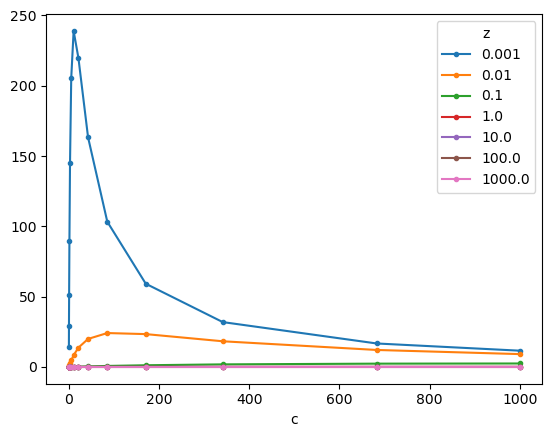

In [57]:
b12.reindex(b12['c'].sort_values().index).plot(x='c', y=z_list,  style='.-' )

In [49]:
b12

z,T,P,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,c
0,12,2,13.996442,0.166747,0.001699,0.000017,1.702322e-07,1.702354e-09,1.702357e-11,0.166667
1,12,4,28.844640,0.358853,0.003677,0.000037,3.686502e-07,3.686593e-09,3.686602e-11,0.333333
2,12,8,50.877080,0.662000,0.006824,0.000068,6.847021e-07,6.847233e-09,6.847254e-11,0.666667
3,12,16,89.327758,1.271426,0.013273,0.000133,1.333765e-06,1.333824e-08,1.333830e-10,1.333333
4,12,32,145.174196,2.469867,0.026539,0.000267,2.676104e-06,2.676307e-08,2.676327e-10,2.666667
5,12,64,205.315906,4.624317,0.052262,0.000530,5.303156e-06,5.303867e-08,5.303939e-10,5.333333
6,12,128,239.019565,8.324374,0.103062,0.001056,1.058599e-05,1.058862e-07,1.058888e-09,10.666667
7,12,256,219.665837,13.736642,0.199842,0.002092,2.101667e-05,2.102661e-07,2.102761e-09,21.333333
8,12,512,163.356853,19.913344,0.380421,0.004151,4.189973e-05,4.193880e-07,4.194271e-09,42.666667
9,12,1024,103.285945,24.099365,0.697536,0.008213,8.362136e-05,8.377398e-07,8.378928e-09,85.333333


### Out-of-sample $R^2$ 

